In [1]:
from bokeh.io import output_notebook # to plot "show()" on the notebook, without opening a browser
output_notebook()

Loading BokehJS ...

In [2]:
from bloqade import var, save, load, piecewise_linear, rydberg_h
from bloqade.atom_arrangement import Chain, Square, Honeycomb
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
n_atoms = 9
lattice_spacing = 6.1
atom_pos = Chain(n_atoms, lattice_spacing=lattice_spacing)

atom_pos.show()

In [83]:
def omega_with_tweaks(num_tweaks):
    duration = 9.8
    low = 0.0
    high = 10.7
    interval = duration/num_tweaks
    omega_durations_scaring = [interval for _ in range(num_tweaks)]
    omega_scaring = [low if i % 2 == 0 else high for i in range(num_tweaks+1)]
    return omega_durations_scaring, omega_scaring

In [84]:
# State Preparation
delta_durations_state_prep = [0.3, 1.6, 0.3]
delta_state_prep = [-18.8, -18.8, 16.3, 16.3] # longer than durations by 1

omega_durations_state_prep = [0.3, 1.6, 0.3]
omega_state_prep = [0.0, 15.7, 15.7, 0.0] # longer than durations by 1

# Scaring
delta_durations_scaring = [0.2, 9.6]
delta_scaring = [16.3, 0.0, 0.0] # longer than durations by 1

omega_durations_scaring, omega_scaring = omega_with_tweaks(20)

In [85]:
Omega = piecewise_linear(omega_durations_state_prep+omega_durations_scaring, omega_state_prep[:-1]+omega_scaring)
Omega.show()

In [86]:
run_time = var("run_time")

quantum_scar_program = (
    atom_pos
    # define detuning waveform
    .rydberg.detuning.uniform.piecewise_linear(
        delta_durations_state_prep, delta_state_prep # delta stateprep durations and values
    )
    .piecewise_linear(delta_durations_scaring, delta_scaring) # delta scaring durations and values
    # slice the detuning waveform
    .slice(start=0, stop=run_time)
    # define rabi waveform
    .amplitude.uniform.piecewise_linear(omega_durations_state_prep, omega_state_prep) # omega stateprep durations and values
    .piecewise_linear(omega_durations_scaring, omega_scaring) # omega scaring durations and values
    # slice waveform, add padding for the linear segment
    .slice(start=0, stop=run_time - 0.065)
    # record the value of the waveform at the end of the slice to "rabi_value"
    .record("rabi_value")
    # append segment to waveform that fixes the value of the waveform to 0
    # at the end of the waveform
    .linear("rabi_value", 0, 0.065)
)

# get run times via the following:
prep_times = np.array([2.2])
scar_times = np.arange(2.2, 12, 0.1)
run_times = np.unique(np.hstack((prep_times, scar_times)))

batch = quantum_scar_program.batch_assign(run_time=run_times)

print(f"State preparation ends at task {len(prep_times)}")
print(f"Tasks in total: {len(run_times)}")

State preparation ends at task 1
Tasks in total: 98


In [87]:
num_shots = 500
emu_batch = batch.bloqade.python().run(num_shots, interaction_picture=True)

In [79]:
emu_batch.report().show()

In [88]:
def Z2(L, prime=True, label_output=True):
    label = ''
    for i in range(L):
        if prime:
            label += str(i % 2)
        else:
            label += str((i + 1) % 2)
    if label_output:
        return label
    else:
        return np.array(Statevector.from_label(label))

def get_z2_probabilities(report):
    z2_probabilities = []

    for count in report.counts():
        z2_probability = count.get("010101010", 0) / sum(list(count.values()))
        z2_probabilities.append(z2_probability)

    return z2_probabilities

In [89]:
z2_probabilities = get_z2_probabilities(emu_batch.report())

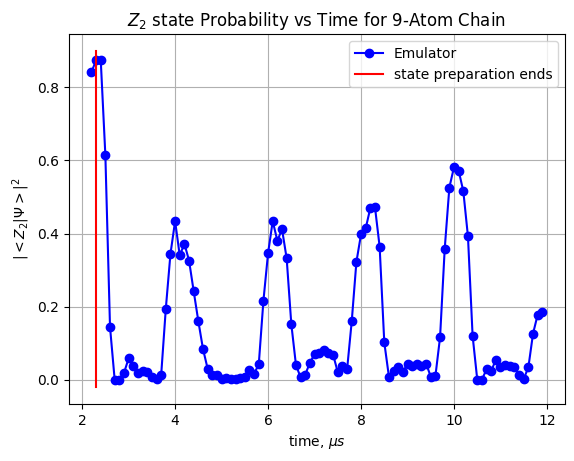

In [94]:
plt.plot(run_times, z2_probabilities, 'o-', label="Emulator", color="blue")
plt.plot([2.3, 2.3], [-0.02, 0.9], 'r-', label='state preparation ends')
plt.xlabel('time, $\mu s$')
plt.ylabel(f"$|<Z_2|\Psi>|^2$")
plt.title(f'$Z_2$ state Probability vs Time for {n_atoms}-Atom Chain')
plt.legend()
plt.grid()

In [95]:
for x, y in zip(run_times, z2_probabilities):
    print((round(x, 1), round(y, 2)), end=', ')

(2.2, 0.84), (2.3, 0.87), (2.4, 0.88), (2.5, 0.61), (2.6, 0.14), (2.7, 0.0), (2.8, 0.0), (2.9, 0.02), (3.0, 0.06), (3.1, 0.04), (3.2, 0.02), (3.3, 0.02), (3.4, 0.02), (3.5, 0.01), (3.6, 0.0), (3.7, 0.01), (3.8, 0.19), (3.9, 0.34), (4.0, 0.43), (4.1, 0.34), (4.2, 0.37), (4.3, 0.33), (4.4, 0.24), (4.5, 0.16), (4.6, 0.08), (4.7, 0.03), (4.8, 0.01), (4.9, 0.01), (5.0, 0.0), (5.1, 0.0), (5.2, 0.0), (5.3, 0.0), (5.4, 0.0), (5.5, 0.01), (5.6, 0.03), (5.7, 0.02), (5.8, 0.04), (5.9, 0.22), (6.0, 0.35), (6.1, 0.43), (6.2, 0.38), (6.3, 0.41), (6.4, 0.33), (6.5, 0.15), (6.6, 0.04), (6.7, 0.01), (6.8, 0.01), (6.9, 0.05), (7.0, 0.07), (7.1, 0.07), (7.2, 0.08), (7.3, 0.07), (7.4, 0.07), (7.5, 0.02), (7.6, 0.04), (7.7, 0.03), (7.8, 0.16), (7.9, 0.32), (8.0, 0.4), (8.1, 0.41), (8.2, 0.47), (8.3, 0.47), (8.4, 0.36), (8.5, 0.1), (8.6, 0.01), (8.7, 0.02), (8.8, 0.03), (8.9, 0.02), (9.0, 0.04), (9.1, 0.04), (9.2, 0.04), (9.3, 0.04), (9.4, 0.04), (9.5, 0.01), (9.6, 0.01), (9.7, 0.12), (9.8, 0.36), (9.9, 0.5